In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import lr_scheduler
from torch import optim
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from torchvision import models
from torchvision import transforms
from tqdm import tqdm
import pandas as pd
import numpy as np
import cv2
import time
from PIL import Image
import glob

In [2]:
# l = glob.glob('/scratch/groups/rubin/rvignav/input/train/*.jpeg')
# for i in range(6):
#     a = cv2.imread(l[i])
#     a = cv2.resize(a, (400,300))
#     plt.imshow(a)
#     plt.show()
#     scale = 300
#     a = cv2.addWeighted(a, 4, cv2.GaussianBlur(a, (0,0), scale/30), -4, 128)
#     b = np.zeros(a.shape)
#     cv2.circle(b, (int(a.shape[1]/2), int(a.shape[0]/2)), int(scale*0.9), (1,1,1), -1, 8, 0)
#     a = a*b + 128*(1-b)
#     plt.imshow(a)
#     plt.show()


In [3]:
def check_cuda():
    is_cuda = False
    if torch.cuda.is_available():
        is_cuda = True
    return is_cuda

def scaleRadius(img, scale):
#     x = img[int(img.shape[0] / 2), :, :].sum(1)
#     r = (x > x.mean() / 10).sum() / 2
#     s = scale * 1.0 / r
#     return cv2.resize(img, (0,0), fx=s, fy=s)
    return cv2.resize(img, (256,256))

class DRDataset(Dataset):
    def __init__(self, csv_path):
        # Transforms
        self.to_tensor = transforms.ToTensor()
        # Read the csv file
        self.data_info = pd.read_csv(csv_path, header=None)
        # First column contains the image paths
        self.image_arr = np.asarray(self.data_info.iloc[:, 0])
        # Second column is the labels
        self.label_arr = np.asarray(self.data_info.iloc[:, 1])
        # Calculate len
        self.data_len = len(self.data_info.index)

    def __getitem__(self, index):
        single_image_name = '/scratch/groups/rubin/rvignav/input/train/' + self.image_arr[index] + '.jpeg'
#         img_as_img = Image.open(single_image_name)
        a = cv2.imread(single_image_name)
        
        scale = 300
        a = scaleRadius(a, scale)
        a = cv2.addWeighted(a, 4, cv2.GaussianBlur(a, (0,0), scale/30), -4, 128)
        b = np.zeros(a.shape)
        cv2.circle(b, (int(a.shape[1]/2), int(a.shape[0]/2)), int(scale*0.9), (1,1,1), -1, 8, 0)
        a = a*b + 128*(1-b)
        a = cv2.resize(a, (256,256))
    
#         gamma = 1.3
#         lookUpTable = np.empty((1,256), np.uint8)
#         for i in range(256):
#             lookUpTable[0,i] = np.clip(pow(i / 255.0, gamma) * 255.0, 0, 255)
#         img_as_img = cv2.LUT(np.uint8(img_as_img), lookUpTable)
#         img_as_img = cv2.resize(img_as_img, (256,256))

        # Transform image to tensor
        
        img_as_tensor = self.to_tensor(a)

#         img_as_tensor = self.to_tensor(img_as_img)

        # Get label(class) of the image based on the cropped pandas column
        single_image_label = self.label_arr[index]

        return (img_as_tensor, single_image_label)

    def __len__(self):
        return self.data_len
    
full_dataset = DRDataset('/home/users/rvignav/trainLabels.csv') #'/scratch/groups/rubin/rvignav/input/train/trainLabels.csv'

train_size = int(0.9 * len(full_dataset)) 
val_size = int(0.05 * len(full_dataset)) 
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(full_dataset, 
                                                                         [train_size, val_size, test_size])

print(train_dataset)

print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))
train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32,
                                          shuffle=True, num_workers=4, pin_memory=True)

valid_data_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32,
                                          shuffle=True, num_workers=4, pin_memory=True)

test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32,
                                          shuffle=True)

10707
594
596


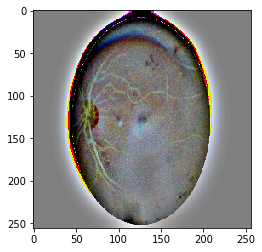

tensor(2): moderate


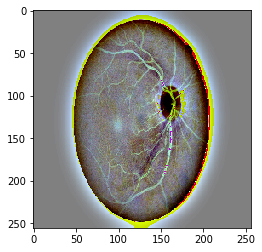

tensor(1): mild


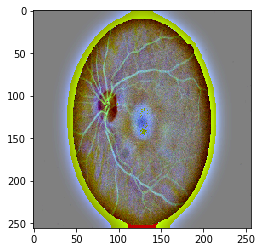

tensor(1): mild


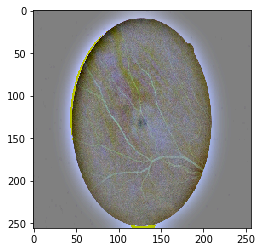

tensor(3): severe


In [4]:
"""
0 - No DR
1 - Mild
2 - Moderate
3 - Severe
4 - Proliferative DR
"""
classes = ('none', 'mild', 'moderate', 'severe', 'proliferative')

for data, target in train_data_loader:
    for i in range(0, 4):  
        im = data[i]
        im = torch.squeeze(im)
        plt.imshow(np.transpose(im.numpy(), (1, 2, 0)), cmap='gray')
        plt.show()
        print(str(target[i]) + ": " + classes[(int)(target[i])])
    break

In [ ]:
#resnet50, imagenet weights, freeze some layers?

# class Net(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.ConvLayer1 = nn.Sequential(
#             nn.Conv2d(3, 8, 3), # inp (3, 512, 512)
#             nn.Conv2d(8, 16, 3),
#             nn.MaxPool2d(2),
#             nn.ReLU() # op (16, 256, 256)
#         )
#         self.ConvLayer2 = nn.Sequential(
#             nn.Conv2d(16, 32, 5), # inp (16, 256, 256)
#             nn.Conv2d(32, 32, 3),
#             nn.MaxPool2d(4),
#             nn.ReLU() # op (32, 64, 64)
#         )
#         self.ConvLayer3 = nn.Sequential(
#             nn.Conv2d(32, 64, 3), # inp (32, 64, 64)
#             nn.Conv2d(64, 64, 5),
#             nn.MaxPool2d(2),
#             nn.ReLU() # op (64, 32, 32)
#         )
#         self.Lin1 = nn.Linear(9216, 5) #1024
        
        
#     def forward(self, x):
#         x = self.ConvLayer1(x)
#         x = self.ConvLayer2(x)
#         x = self.ConvLayer3(x)
#         x = x.view(x.size(0), -1)
#         x = self.Lin1(x)
#         return F.log_softmax(x, dim = 1)

# model = Net()
# model = torch.load('/scratch/groups/rubin/final_preprocessed_balanced_not_stylized')
# model.eval()

from torchsummary import summary
from collections import OrderedDict

model = models.resnet50(pretrained=True, progress=False)

# classifier = nn.Sequential(OrderedDict([('fc1', nn.Linear(25088, 512)),
#                            ('relu', nn.ReLU()), 
#                            ('dropout', nn.Dropout(p=0.337)),
#                            ('fc2', nn.Linear(512, 5)),
#                            ('output', nn.LogSoftmax(dim=1))
#                              ]))

# model.classifier = classifier
model.fc = nn.Sequential(OrderedDict([('fc1', nn.Linear(2048, 512)),
                           ('relu', nn.ReLU()), 
                           ('dropout', nn.Dropout(p=0.337)),
                           ('fc2', nn.Linear(512, 5)),
                           ('output', nn.LogSoftmax(dim=1))
                             ]))

is_cuda = check_cuda()
if is_cuda:
    model.cuda()
    
print(summary(model, (3, 256, 256)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]           4,096
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]          16,384
      BatchNorm2d-12          [-1, 256, 64, 64]             512
           Conv2d-13          [-1, 256, 64, 64]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
def validate(model, valid_data_loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in valid_data_loader:
            images, labels = data
            images = np.array(images, int) 
            images = torch.Tensor(images).float()
            labels = np.array(labels, int) 
            labels = torch.Tensor(labels).long()
            images, labels = images.cuda(), labels.cuda()
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

num_epochs = 5 #20

criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.5) #momentum=0.9
optimizer = optim.Adam(model.parameters(), lr=1e-4)
for epoch in tqdm(range(num_epochs)): 

    running_loss = 0.0
    
#     io = 0
#     forward = 0
#     backward = 0
    
    for i, data in enumerate(train_data_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
#         start_time = time.time()
        
        inputs, labels = data
        inputs = np.array(inputs, int) 
        inputs = torch.Tensor(inputs).float()
        labels = np.array(labels, int) 
        labels = torch.Tensor(labels).long()
        inputs, labels = inputs.cuda(), labels.cuda()
        # zero the parameter gradients
        optimizer.zero_grad()
        
#         io += time.time() - start_time
        
#         if i % 100 == 0:
#             print("--- I/O %s seconds ---" % io)
#             io = 0

        # forward + backward + optimize
#         start_time = time.time()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
#         forward += time.time() - start_time
#         if i % 100 == 0:
#             print("--- FORWARD %s seconds ---" % forward)
#             forward = 0
        
#         start_time = time.time()
        loss.backward()
        optimizer.step()
#         backward += time.time() - start_time
#         if i % 100 == 0:
#             print("--- BACKWARD %s seconds ---" % backward)
#             backward = 0

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0
    
    print("train_acc: " + str(validate(model, train_data_loader)))
    print("val_acc: " + str(validate(model, valid_data_loader)))
    
    torch.save(model, '/scratch/groups/rubin/adam_balanced_not_stylized_' + str(epoch+1) + 'epochs')
print('Finished Training')

  0%|          | 0/5 [00:00<?, ?it/s]

[1,   100] loss: 1.298
[1,   200] loss: 1.171
[1,   300] loss: 1.109
train_acc: 54.88932474082376
val_acc: 51.178451178451176


 20%|██        | 1/5 [1:02:53<4:11:35, 3773.98s/it]

[2,   100] loss: 1.010
[2,   200] loss: 0.993


In [ ]:
# torch.save(model, '/scratch/groups/rubin/final_preprocessed_balanced_not_stylized')

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_data_loader:
        images, labels = data
        images = np.array(images, int) 
        images = torch.Tensor(images).float()
        labels = np.array(labels, int) 
        labels = torch.Tensor(labels).long()
        images, labels = images.cuda(), labels.cuda()
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

#measure sensitivity for each class
#measure AUC (AUC: 0.75+ is our target) & ROC (for the all data and for the balanced dataset)
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html#sklearn.metrics.classification_report